In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import src.grimoire as Grimoire
from src.grimoire import By
import src.decks as Decks


In [2]:
commander = "Kodama of the West Tree"
# grim = Grimoire.Grimoire(omnicomprehensive=True)
# Decks.fetch(By.COMMANDER, commander)
grim = Grimoire.fetch(By.COMMANDER,commander,check_if_playable=True)


Carico le carte dal grimorio di Kodama of the West Tree


In [3]:
from src.card import Filters
# Crea la matrice di correlazione
df = grim.dataframe( 
    positive_filters=[
        Filters.isLegalInCommander,
        Filters.isCreature
    ], 
    negative_filters=[
        Filters.isToken
    ],
    additional_data={
        # "is_creature": lambda card: int(Type.Creature.name in card.types),
        # "#keywords" : lambda card: len(card.keywords),
        "#words" : lambda card: card.text.count(' ')+1,
        # "is_black": lambda card: int(card.color_identity['B']),
        # "is_white": lambda card: int(card.color_identity['W']),
        # "is_colorless": lambda card: int(all(not v for v in card.color_identity.values())),
        "is_legendary": lambda card: int("Legendary" in card.super_types),
        "#act_abilities": lambda card: int(card.count_active_abilities()),
        "#trigg_abilities": lambda card: int(card.count_trigger_abilities()),
        "#mana_production": lambda card: int(card.count_mana_production())
    })

In [4]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler # type: ignore

numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
df_scaled = df.copy()
scaler = StandardScaler()
# scaler = MinMaxScaler()
# scaler = RobustScaler()
df_scaled[numeric_cols] =  scaler.fit_transform(df[numeric_cols])
correlation_matrix = df_scaled.corr()

In [5]:
grim.remove(9092494)

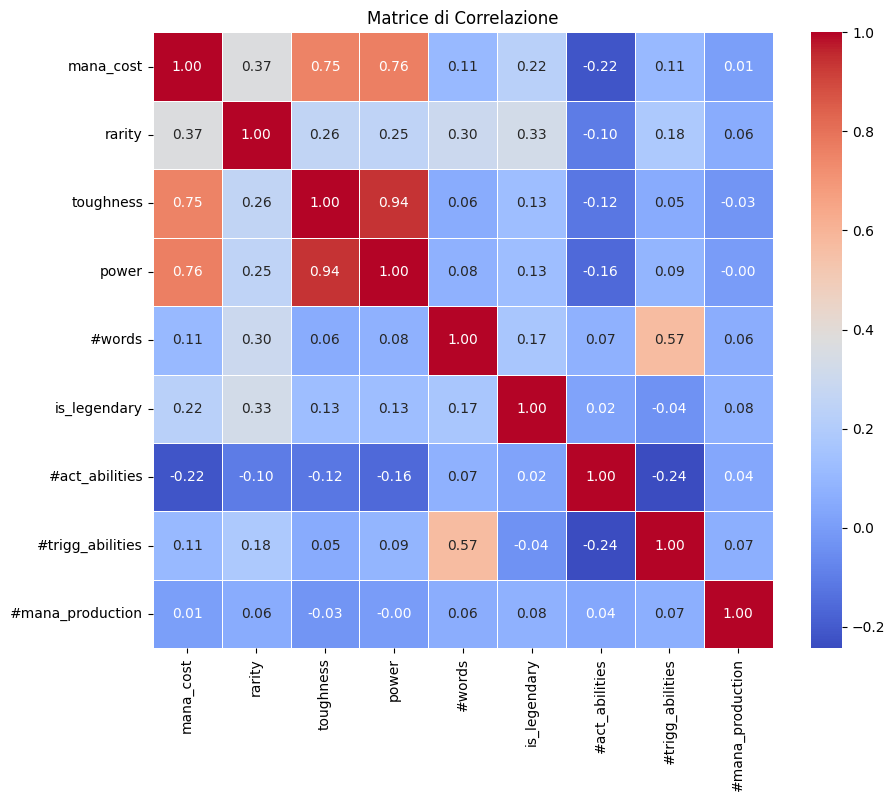

In [6]:
import numpy as np # type: ignore
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=np.round(correlation_matrix, 2), cmap='coolwarm', 
            linewidths=0.5, fmt=".2f", annot_kws={"size": 10})
plt.title('Matrice di Correlazione')
plt.show()


In [7]:
import ipywidgets as widgets
from IPython.display import display
import numpy as np


# Funzione per aggiornare la heatmap
def update_heatmap(limit):
    # Crea una maschera booleana per nascondere le annotazioni non significative
    mask_annot = (correlation_matrix < -limit) | (correlation_matrix > limit)

    # Crea una matrice di annotazioni, sostituendo i valori non significativi con NaN
    annot = np.where(mask_annot, np.round(correlation_matrix, 2), np.nan)

    # Stampa la heatmap senza annotazioni per le celle non significative
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=annot, cmap='coolwarm', linewidths=0.5, annot_kws={"size": 8}, mask=np.isnan(annot))
    plt.title(f'Heatmap with Limit: {limit}')
    plt.show()

# Crea un widget per limit
limit_slider = widgets.FloatSlider(value=0.15, min=0.00, max=0.23, step=0.001, description='Limit:')


# # Mostra la heatmap iniziale
# update_heatmap(limit_slider.value)

# Collega il widget alla funzione di aggiornamento
widgets.interactive(update_heatmap, limit=limit_slider)

interactive(children=(FloatSlider(value=0.15, description='Limit:', max=0.23, step=0.001), Output()), _dom_cla…

In [8]:
matrix = grim.similarity_matrix()
rows, cols = matrix.shape

if rows != cols:
    raise ValueError("La matrice non è quadrata.")
if not (matrix == matrix.T).all():
    raise ValueError("La matrice non è simmetrica.")
if (matrix < 0).any():
    raise ValueError("La matrice contiene valori negativi.")

In [9]:

# import imageio.v2 as imageio
# # Definisci i limiti per la GIF
# limits = np.arange(0, 0.24, 0.01)

# # Lista per salvare i frame
# frames = []

# # Genera i frame
# for limit in limits:
#     plt.figure(figsize=(10, 8))
    
#     # Crea una maschera booleana per nascondere le annotazioni non significative
#     mask_annot = (correlation_matrix < -limit) | (correlation_matrix > limit)

#     # Crea una matrice di annotazioni
#     annot = np.where(mask_annot, np.round(correlation_matrix, 2), np.nan)

#     # Stampa la heatmap
#     sns.heatmap(correlation_matrix, annot=annot, cmap='coolwarm', linewidths=0.5, annot_kws={"size": 8}, mask=np.isnan(annot))
#     plt.title(f'Heatmap with Limit: {limit:.2f}')
    
#     # Salva il frame come immagine
#     plt.savefig(f'frame_{limit:.2f}.png')
#     plt.close()

#     # Aggiungi il frame alla lista
#     frames.append(imageio.imread(f'frame_{limit:.2f}.png'))

# # Crea una GIF animata
# imageio.mimsave('heatmap_animation.gif', frames, duration=4)

# # Rimuovi le immagini temporanee (opzionale)
# import os
# for limit in limits:
#     os.remove(f'frame_{limit:.2f}.png')

# print("GIF animata creata: heatmap_animation.gif")

/tmp/ipykernel_11450/928273997.py:14: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  dendrogram = sch.dendrogram(sch.linkage(distanze, method='complete'), labels=deck_ids)


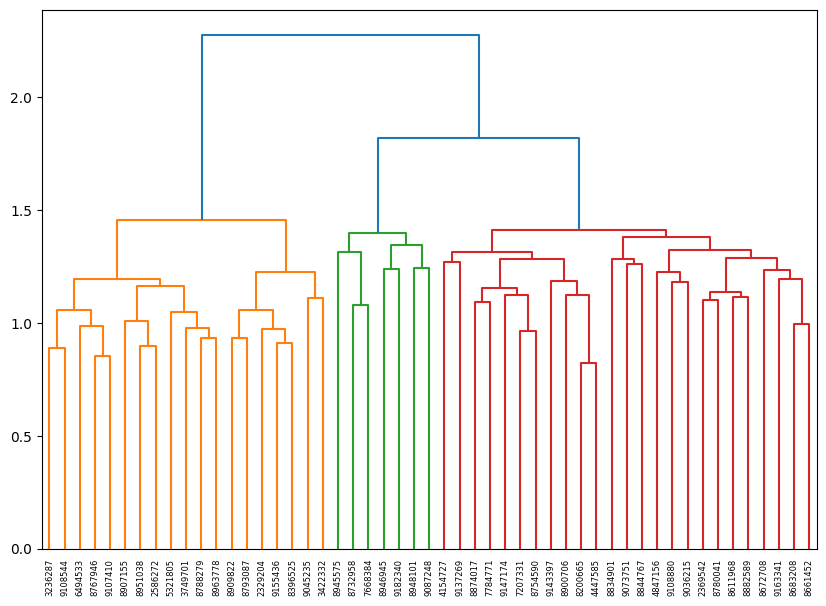

In [32]:
from sklearn.cluster import AffinityPropagation
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch


clustering = AffinityPropagation(preference=10)

distanze = 1 - matrix
deck_ids = list(grim.get_all_deck_ids())
labels = clustering.fit_predict(distanze)


plt.figure(figsize=(10, 7))
dendrogram = sch.dendrogram(sch.linkage(distanze, method='complete'), labels=deck_ids)
plt.show()

In [23]:

from sklearn.metrics import silhouette_score
# Calcola il silhouette score
score = silhouette_score(distanze, labels, metric='precomputed')
print(f'Silhouette Score: {score:.3f}')

Silhouette Score: 0.005


/tmp/ipykernel_11450/904052244.py:4: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(distanze, method='average')


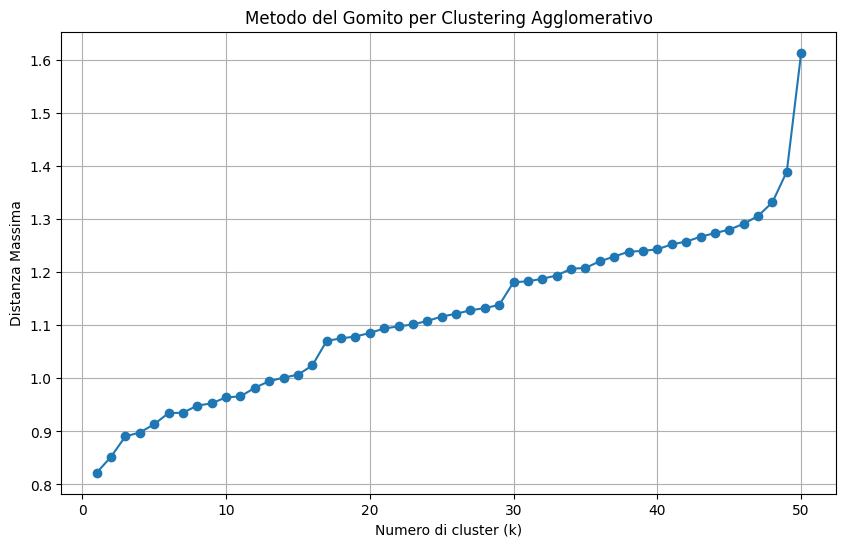

In [24]:

from scipy.cluster.hierarchy import linkage

# Clustering agglomerativo
Z = linkage(distanze, method='average')

# Calcola le distanze per il metodo del gomito
max_distanze = []
for i in range(1, len(matrix)):
    # Aggiungi la distanza massima dal dendrogramma
    max_distanze.append(max(Z[:i, 2]))

# Grafico del metodo del gomito
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(matrix)), max_distanze, marker='o')
plt.title('Metodo del Gomito per Clustering Agglomerativo')
plt.xlabel('Numero di cluster (k)')
plt.ylabel('Distanza Massima')
plt.grid()
plt.show()